<a href="https://colab.research.google.com/github/GENI-Technology/GENITechLearningTogether/blob/main/Weight_Transfer_within_Identical_Transformer_Models_V001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://geni.asia/wp-content/uploads/2021/12/Full_logo_Color.png" alt="GENI Technology (Myanmar)" width="150">




**Acknowledgments**

This tutorial was created with the help of several valuable resources and collaborations.

* **Large Language Models:** We would like to acknowledge the valuable assistance of **Google Gemini** and **ChatGPT** for their capabilities in language generation and information retrieval. These large language models were instrumental in providing insights and generating draft text, which were subsequently refined and edited for clarity and accuracy.
* **Research Team:** We are grateful to [GENI Technology research team](https://geni.asia/research-internship-batch-1/) for their contributions, guidance, and support throughout the development of this tutorial. Their expertise and collaboration were essential for ensuring the quality and comprehensiveness of this work.

We hope this tutorial proves to be informative and helpful. Please feel free to reach out if you have any questions or feedback.



## Introduction

Have you ever found yourself in a situation where you need to adapt an existing **source model** (i.e., pretrained transformer model) for a new task, but its vocabulary does not quite match the available data? Perhaps you need to switch tokenizers to better handle the specific domain of your new task.

This can be especially tricky when the source model's **embedding layer**, which maps words to numerical representations, relies on the original tokenizer's vocabulary. Changing the tokenizer means the word meanings encoded in the embedding layer no longer align with the new vocabulary.

This guide will walk you through a specific solution for tackling this challenge. We will explore how to **transfer weights** from a **destination model** that uses the desired tokenizer to your source model. This approach involves copying the **embedding layer weights** and potentially some **encoder layer weights** from the destination model to your source model.

By the end of this tutorial, you will be equipped to:

* Understand the rationale behind weight transfer in this scenario.
* Implement the process of transferring embedding and encoder layer weights from the destination to the source model.
* Fine-tune the source model to adapt it to your specific task and dataset (**Coming Soon!**).

This approach allows you to leverage the knowledge and understanding of the destination model's trained weights while adapting your source model to work effectively with your new tokenizer and task data.


## Why This Approach Works

The approach of transferring weights from a destination model to a source model with a mismatched tokenizer works due to two key factors: **vocabulary alignment** and **leveraging pre-trained knowledge**.

**1. Vocabulary Alignment**

When you replace the source model's tokenizer with the destination model's tokenizer, their vocabularies become **aligned**. This means that the words and their corresponding numerical representations (embeddings) are consistent between the two models.

By transferring the **embedding layer weights** from the destination model to the source model, you directly copy the pre-trained word representations that are already aligned with the new vocabulary. This ensures that the source model understands the meanings of words within the new vocabulary without needing to retrain the entire embedding layer from scratch.

**2. Leveraging Pre-trained Knowledge**

Beyond just vocabulary alignment, transferring **encoder layer weights**, particularly from earlier layers, can be beneficial. The **encoder** is responsible for capturing relationships between words and extracting meaningful features from the sequence of embeddings.

By transferring some encoder layer weights from the destination model, you potentially leverage the knowledge it has learned about these features in the context of the new vocabulary. This can:

* **Improve feature understanding** The transferred weights might encode better ways to extract meaningful features from the aligned sequences of embeddings.
* **Accelerate training** The transferred weights can provide the source model with a good starting point for training, potentially allowing it to reach a strong performance level faster compared to training from scratch.

**Important to Note:**

* **Fine-tuning is crucial:** Even after transferring weights, **fine-tuning** the source model on your specific task and dataset is essential. This allows the model to adapt to any nuances specific to your data that might not have been perfectly captured by the destination model.
* **Partial transfer might be optimal:** Not all encoder layers need to be transferred. It's worth experimenting to see if focusing on earlier layers that typically capture more general language features is beneficial.

``
Overall, transferring weights from a destination model with a matching tokenizer to a source model allows you to efficiently adapt the source model to a new task while leveraging the pre-trained knowledge gained by the destination model.
``

## Setting Up the Environment in Google Colab

This section guides you through setting up the necessary libraries for this tutorial within a Google Colab environment.

**Google Colab:** Google Colab is a free platform that allows you to run Python code in your web browser, eliminating the need for local installations. It provides access to powerful hardware resources like GPUs, making it ideal for computationally intensive tasks like deep learning.

**Steps:**

1. **Open Google Colab:** Visit [https://research.google.com/colaboratory/](https://research.google.com/colaboratory/) in your web browser.
2. **Create a New Notebook:** Click on "File" -> "New Notebook" to create a new notebook where we will execute the code.

**Installing Required Libraries:**

The following code snippet installs the necessary libraries for this tutorial:

```python
!pip install -q -U bitsandbytes transformers peft accelerate datasets trl einops
```

**Explanation:**

* `!pip`: This symbol indicates a system command executed within the Colab environment.
* `install`: This keyword specifies the action to be performed, which is installing packages.
* `-q`: This flag suppresses output from the installation process, keeping the notebook cleaner.
* `-U`: This flag ensures that the latest version of each library is installed, if available.
* `bitsandbytes`, `transformers`, `peft`, `accelerate`, `datasets`, `trl`, `einops`: These are the names of the libraries we need to install.

**Running the Code:**

1. Click inside the first code cell (the box containing the above code).
2. Press "Shift" + "Enter" or click the "Run" button (play symbol) at the top of the cell to execute the code.

**Verification:**

Once the code execution is complete, you should see no errors or warnings in the output below the code cell. This indicates that the libraries have been successfully installed in your Colab environment.

**Additional Notes:**

* You may need to restart your Colab runtime occasionally, especially after installing new libraries. This ensures that the changes are reflected in the environment.
* Google Colab has resource limitations for free usage. If you encounter any resource issues, you might need to upgrade to a paid tier or adjust your code for efficiency.

In [1]:
!pip install -q -U bitsandbytes
!pip install -q -U transformers
!pip install -q -U peft
!pip install -q -U accelerate
!pip install -q -U datasets
!pip install -q -U trl
!pip install -q -U einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.5 MB/s eta 0:00:00


**Core NLP Libraries**

* **transformers (from Hugging Face):** This is a powerhouse library for NLP. It provides:
    * **Pre-trained Models:** Vast collection of state-of-the-art Transformer-based models for tasks like text classification, translation, question answering, etc.  Think of them as 'brains' already trained on massive amounts of data.
    * **Tokenizers:**  Tools to break sentences into wordpieces that the models understand.
    * **Pipelines:** Easy-to-use components for common NLP tasks.

* **datasets (from Hugging Face):**  A centralized platform for accessing and using a huge range of publicly available datasets for NLP. You can load many common datasets for training or evaluation purposes with minimal effort.

**Specialized for Transfer Learning & Efficiency**

* **peft:** Facilitates fine-tuning of pre-trained models with specialized techniques and flexibility. Crucial for effectively adapting models to your specific downstream tasks.

* **trl:** Another transfer learning library. While less well-known, it might have specific utilities for certain weight transfer or knowledge distillation approaches.

* **accelerate (from Hugging Face):** Optimizes training across different hardware (CPUs, GPUs, TPUs) and simplifies distributed training (using multiple computing units simultaneously for faster training).

* **bitsandbytes:** Helps with quantization of models. This reduces model size and computational cost, making models fit into resource-limited environments or run more efficiently.

* **einops:** Provides a flexible and intuitive way to manipulate and reshape tensors (the fundamental data structures within NLP models). This can streamline code for complex tensor operations.

**How They Work Together**

In this tutorial setup, these libraries work in conjunction to:

1. Load pre-trained models (`transformers`) and their associated tokenizers, potentially from a destination model that aligns with your new task.
2. Extract relevant weights from the destination model related to embeddings or encoder layers.
3. Transfer and incorporate these weights into your source model.
4. Leverage the other libraries to optimize (`accelerate`, `bitsandbytes`) and fine-tune (`peft`) your enhanced source model on your specific downstream task while using relevant datasets (`datasets`).


## Importing Essential Libraries for NLP and Transfer Learning

This section dives into the various libraries imported for this tutorial and their roles in enabling the transfer learning approach:

**From Transformers:**

* **AutoModelForCausalLM:** Loads any pre-trained causal language model (like GPT-2) from the Hugging Face model hub based on a model identifier. In our case, it will be used for the source model.
* **AutoTokenizer:** Automatically loads the tokenizer associated with the chosen model (from AutoModelForCausalLM) for handling text pre-processing and tokenization.
* **BitsAndBytesConfig:** Configuration for model quantization using BitsAndBytes library (potentially used for efficiency improvements).
* **HfArgumentParser:** Helps parse command-line arguments for fine-tuning, making hyperparameter tuning and experiment management easier.
* **TrainingArguments:** Defines training arguments like learning rate, epochs, etc., for fine-tuning the model.
* **pipeline:** Provides pre-trained pipelines for common NLP tasks like text generation, summarization, and translation.
* **logging:** Manages logging messages during training or inference.
* **TextStreamer:** (Optional) Enables text streaming for large datasets, potentially improving memory efficiency during training.

**From Peft:**

* **LoraConfig:** Configuration for training with Low-Rank AdaGrad (LORA) for memory optimization.
* **PeftModel:** Core class used to create and manage Peft models, enabling efficient fine-tuning.
* **prepare_model_for_kbit_training:** Prepares the model for training with limited precision (e.g., 8-bit) using BitsAndBytes.
* **get_peft_model:** Retrieves a Peft model for fine-tuning.

**Standard Libraries:**

* **os:** Provides operating system functionalities like path manipulation.
* **torch:** The core deep learning library used for building and training models.
* **platform:** Provides information about the system platform and environment.
* **warnings:** Used to handle and manage warnings during code execution.

**From Datasets:**

* **load_dataset:** Loads datasets from the Hugging Face Hub or local files.
* **Dataset, DatasetDict:** Classes for representing and managing datasets.

**From TRL:**

* **SFTTrainer:** A trainer class from the TRL library (potentially used for specific transfer learning approaches).

**From Hugging Face Hub:**

* **notebook_login:** Allows authentication with the Hugging Face Hub for potential model upload or download (optional).

**Additional Libraries:**

* **pandas (pd):** Used for data manipulation and analysis (potentially for data pre-processing or evaluation).
* **sklearn.model_selection:** Provides functions for splitting data into training and validation sets.

**Key Points:**

* We leverage libraries from Hugging Face (Transformers and Datasets) for core NLP functionalities like model loading, tokenization, and dataset access.
* Peft and TRL libraries offer additional functionalities related to efficient fine-tuning and transfer learning techniques.
* Standard libraries like `os`, `torch`, and `platform` provide essential functionalities for system interaction and deep learning operations.
* `pandas` and `sklearn` might be used for data manipulation and processing tasks.

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, HfArgumentParser, TrainingArguments, pipeline, logging, TextStreamer
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training, get_peft_model
import os,torch, platform, warnings
from datasets import load_dataset, Dataset, DatasetDict
from trl import SFTTrainer
from huggingface_hub import notebook_login
import pandas as pd
from sklearn.model_selection import train_test_split

## Checking Your System Environment

Before diving into the tutorial, it's essential to check your system's specifications to ensure it can handle the computational demands of working with deep learning models. This code snippet helps you gather this information:

```python
import torch
import platform

def print_system_specs():
  """
  Prints information about your system's hardware and software environment.
  """
  # Check if CUDA is available
  is_cuda_available = torch.cuda.is_available()
  print("CUDA Available:", is_cuda_available)

  # Get the number of available CUDA devices
  num_cuda_devices = torch.cuda.device_count()
  print("Number of CUDA devices:", num_cuda_devices)

  if is_cuda_available:
    for i in range(num_cuda_devices):
      # Get CUDA device properties
      device = torch.device('cuda', i)
      print(f"--- CUDA Device {i} ---")
      print("Name:", torch.cuda.get_device_name(i))
      print("Compute Capability:", torch.cuda.get_device_capability(i))
      print("Total Memory:", torch.cuda.get_device_properties(i).total_memory, "bytes")

  # Get CPU information
  print("--- CPU Information ---")
  print("Processor:", platform.processor())
  print("System:", platform.system(), platform.release())
  print("Python Version:", platform.python_version())

print_system_specs()
```

**Explanation:**

1. **Importing Libraries:**
    * `torch`: This is the primary deep learning library used in this tutorial.
    * `platform`: This standard Python library provides information about the system's platform and environment.

2. **`print_system_specs()` function:**
    * This function gathers and prints system information.
    * **CUDA Check:** It checks if CUDA, a parallel computing platform for GPUs, is available using `torch.cuda.is_available()`.
    * **Number of CUDA devices:** It retrieves the number of available CUDA devices with `torch.cuda.device_count()`.
    * **CUDA device details (if available):** It iterates through each CUDA device, getting its name, compute capability, and total memory using `torch.cuda` functions.
    * **CPU information:** It prints information about the CPU processor, operating system, and Python version using `platform` module functions.

3. **Calling the Function:**
    * The last line (`print_system_specs()`) executes the function, printing the gathered information to the console.

**Running the Code:**

1. Copy and paste the code into your Python environment or notebook.
2. Run the code. It will display details like:
    * Whether CUDA is available.
    * The number of available CUDA devices (if any).
    * Details about each CUDA device (name, compute capability, memory).
    * CPU information (processor, operating system, Python version).

**Interpretation:**

* **CUDA Availability:** If working with GPUs is beneficial for your task, having CUDA available is crucial. This allows leveraging the parallel processing power of GPUs for faster training and inference.
* **Number of CUDA Devices:** If you have multiple GPUs, you might be able to utilize them for distributed training, further accelerating the process.
* **CUDA Device Details:** Knowing the compute capability and memory of your GPU(s) helps you understand their processing power and limitations.
* **CPU Information:** While GPUs are often preferred for deep learning, understanding your CPU specifications is still valuable, as some operations might still rely on it.

This information can help you assess the suitability of your system for running the code effectively and potentially guide any adjustments needed for optimal performance.

In [2]:
def print_system_specs():
    # Check if CUDA is available
    is_cuda_available = torch.cuda.is_available()
    print("CUDA Available:", is_cuda_available)
# Get the number of available CUDA devices
    num_cuda_devices = torch.cuda.device_count()
    print("Number of CUDA devices:", num_cuda_devices)
    if is_cuda_available:
        for i in range(num_cuda_devices):
            # Get CUDA device properties
            device = torch.device('cuda', i)
            print(f"--- CUDA Device {i} ---")
            print("Name:", torch.cuda.get_device_name(i))
            print("Compute Capability:", torch.cuda.get_device_capability(i))
            print("Total Memory:", torch.cuda.get_device_properties(i).total_memory, "bytes")
    # Get CPU information
    print("--- CPU Information ---")
    print("Processor:", platform.processor())
    print("System:", platform.system(), platform.release())
    print("Python Version:", platform.python_version())
print_system_specs()

CUDA Available: True
Number of CUDA devices: 1
--- CUDA Device 0 ---
Name: Tesla T4
Compute Capability: (7, 5)
Total Memory: 15835660288 bytes
--- CPU Information ---
Processor: x86_64
System: Linux 6.1.58+
Python Version: 3.10.12


## Loading Pretrained Tokenizer for Weight Transfer Transformer Tutorial

This section focuses on loading a pre-trained tokenizer using the `AutoTokenizer` function from the `transformers` library. Here's a breakdown of the code:

1. **`model_name`:** This variable stores the name of the pre-trained model you intend to use for weight transfer, but it's not directly used in this code snippet.
2. **`tokenizer_name`:** This variable holds the name of the specific tokenizer that corresponds to the pre-trained model you're interested in.
3. **`tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)`:** This line instantiates the `AutoTokenizer` class and loads the tokenizer identified by `tokenizer_name`. This tokenizer will be used to prepare your text data (e.g., tokenizing words and sentences) for compatibility with the pre-trained model you plan to utilize in the weight transfer process.

## Utilizing Mistral-7B-Instruct-v0.2 with SeaLLM-7B-v2's Tokenizer

This section explores the chosen models for the transfer learning approach and the rationale behind using SeaLLM-7B-v2's tokenizer with Mistral-7B-Instruct-v0.2:

**Chosen Models:**

* **Source Model:**
    * **Name:** Mistral-7B-Instruct-v0.2 ([https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2))
    * **Type:** Encoder only model
    * **Language:** English
    * **Strengths:** Potential for generating different creative text formats, like poems, code, scripts, musical pieces, email, letters, etc.

* **Destination Model:**
    * **Name:** SeaLLM-7B-v2 ([https://huggingface.co/models?other=LLM](https://huggingface.co/SeaLLMs/SeaLLM-7B-v2))
    * **Type:** Encoder only model
    * **Languages:** Vietnamese, Indonesian, Thai, Malay, Khmer, Lao, Tagalog, Burmese
    * **Strengths:** Powerful language understanding and generation capabilities, particularly for Southeast Asian languages.

**Rationale for Tokenizer Replacement:**

While both models are large language models (LLMs), they have key differences:

* **Language Focus:** Mistral-7B-Instruct-v0.2 focuses on English, while SeaLLM-7B-v2 supports eight Southeast Asian languages.
* **Task-Specific Fine-tuning:** Mistral-7B-Instruct-v0.2 is fine-tuned for instruction-based tasks, which might influence its vocabulary and tokenization scheme.

**The key reason for using SeaLLM-7B-v2's tokenizer with Mistral-7B-Instruct-v0.2 is to handle potential vocabulary and tokenization misalignments.**

* **Scenario:** If you plan to use Mistral-7B-Instruct-v0.2 for tasks requiring vocabulary specific to Southeast Asian languages, its original tokenizer might not be equipped for this new domain.
* **Solution:** By using SeaLLM-7B-v2's tokenizer, you leverage its understanding of the relevant vocabulary and tokenization for these languages, potentially enhancing the performance of Mistral-7B-Instruct-v0.2 when applied to such tasks.

**Code Snippet:**

```python
model_name = "mistralai/Mistral-7B-Instruct-v0.2"
tokenizer_name = "SeaLLMs/SeaLLM-7B-v2"

```

**Important Note:**

While this approach can be beneficial in specific scenarios, it's crucial to carefully evaluate the potential benefits and drawbacks depending on your specific task and desired outcomes. Misalignment between the model's architecture and the borrowed tokenizer can lead to unintended consequences. It's recommended to experiment and compare the performance with and without this approach for your specific use case.

**References:**

* Mistral-7B-Instruct-v0.2 Model Card: [https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2)
* SeaLLM-7B-v2 Model Card: [https://huggingface.co/SeaLLMs/SeaLLM-7B-v2](https://huggingface.co/models?other=LLM)


In [3]:
# Define Model and Tokenizer
model_name = "mistralai/Mistral-7B-Instruct-v0.2"
tokenizer_name = "SeaLLMs/SeaLLM-7B-v2"

## Using `huggingface-cli login` for Secure Access and Management

While you won't need this command in the specific scenario of using SeaLLM-7B-v2, understanding `huggingface-cli login` is valuable for managing private models on the Hugging Face Hub. Here's an explanation:

**What is `huggingface-cli login`?**

The `huggingface-cli login` command is a tool provided by the Hugging Face Hub for securely logging in to your Hugging Face account from the command line. This login allows you to:

* **Manage private models:** Access, upload, and manage private models stored on your Hugging Face Hub account. Public models don't require login for usage.
* **Track and manage experiments:** Keep track of your experiments and associated versions uploaded to the Hub.
* **Contribute to the Hub community:** Collaborate on projects, share models, and access models shared by other logged-in users.

**When to use `huggingface-cli login`:**

* When you want to upload your own trained models to the Hugging Face Hub for private storage or sharing with collaborators.
* When you want to access and manage models uploaded by other users that have shared access privileges with you.

**How to use `huggingface-cli login`:**

1. **Install the `transformers` library:** If you haven't already, install the `transformers` library, which includes the `huggingface-cli` tool:

```bash
pip install transformers
```

2. **Run the command:**

```bash
huggingface-cli login
```

3. **Follow the instructions:** You'll be prompted to enter your Hugging Face Hub username and password.

**Security:**

* The `huggingface-cli login` command uses secure authentication methods to protect your credentials. It avoids storing your password directly on your machine.
* It's crucial to keep your username and password confidential to maintain the security of your models and avoid unauthorized access.

**Additional Notes:**

* You can manage your login tokens and access settings directly from the Hugging Face Hub user interface ([https://huggingface.co/settings/tokens](https://huggingface.co/settings/tokens)).
* Refer to the official documentation for more details and advanced usage: [https://huggingface.co/docs/huggingface_hub/en/quick-start](https://huggingface.co/docs/huggingface_hub/en/quick-start)

While you won't need this command for the specific models used in your tutorial, understanding its purpose and usage might be valuable for future projects involving private models or collaboration on the Hugging Face Hub.

In [6]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## Efficiently Loading Tokenizers for NLP Tasks

This section delves into the code snippet `tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)`, explaining its role and functionalities within your transfer learning tutorial:

**Purpose:**

This line of code is responsible for **loading the tokenizer associated with a specific pre-trained model** named by `tokenizer_name`.

**Breakdown:**

* **`AutoTokenizer`:** This class from the Transformers library automatically identifies and loads the appropriate tokenizer for the given model name. This eliminates the need for remembering or manually specifying the exact tokenizer class name, simplifying the process.
* **`.from_pretrained(tokenizer_name)`:** This method calls the `from_pretrained` function of the `AutoTokenizer` class.
    * **`tokenizer_name` (argument):** This argument specifies the name of the pre-trained model or tokenizer you want to load. In your case, it will be the name of the tokenizer you want to use (e.g., `"SeaLLMs/SeaLLM-7B-v2"`).

**Functionalities:**

The loaded tokenizer is responsible for:

* **Preprocessing text data:** This involves tasks like splitting text into words or subwords (tokens), handling special characters, and potentially applying additional transformations specific to the model's requirements.
* **Converting text to numerical representations:** The tokenizer converts the preprocessed tokens into numerical encodings that the model can understand and process during training and inference.
* **Handling special tokens:** Tokenizers often define special tokens like padding tokens to ensure sequences have the same length and delimiters like start-of-sequence (SOS) and end-of-sequence (EOS) tokens for contextual understanding.

**Benefits of `AutoTokenizer`:**

* **Efficiency:** It simplifies the process by automatically fetching the correct tokenizer, saving you from manually searching for the corresponding class name.
* **Flexibility:** It works with various pre-trained models from the Hugging Face Hub, making it adaptable to different scenarios within your transfer learning workflow.

**Example Usage:**

```python
tokenizer_name = "bert-base-uncased"  # Example model name
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

# Example usage: Tokenize a sentence
sentence = "This is a sample sentence."
encoded_text = tokenizer(sentence, return_tensors="pt")  # Tokenize and convert to tensors
```


## Analyzing Tokenizer Behavior
This section delves into the analysis of the provided tokenizers, highlighting key observations and potential implications for your transfer learning task:

**1. Code Breakdown:**

- **`tokenizer_list`:** This list contains the names of the two tokenizers being compared: Mistral-7B-Instruct-v0.2 and SeaLLM-7B-v2.
- **Processing Loop:**
    - The code iterates through each tokenizer name.
    - It loads the corresponding tokenizer using `AutoTokenizer.from_pretrained`.
    - Sets the padding token and end-of-sentence token to be the same (`tokenizer.eos_token`) for consistency.
    - Defines an example input text in Burmese (မျက်စိနာတာကို မကူးစက်အောင် ဘယ်လိုကာကွယ်ကြမလဲ!).
    - Tokenizes the input text using `tokenizer.tokenize`.
    - Prints the tokenized output and its length.
    - Retrieves the tokenizer's vocabulary size using `tokenizer.vocab_size`.
    - Appends the token count and vocabulary size to respective lists for comparison.

**2. Observations:**

- **Number of Tokens:**
    - **Mistral-7B-Instruct-v0.2:** Tokenizes the input text into 64 tokens.
    - **SeaLLM-7B-v2:** Tokenizes the same text into only 14 tokens.
- **Vocabulary Size:**
    - **Mistral-7B-Instruct-v0.2:** Has a vocabulary size of 32,000.
    - **SeaLLM-7B-v2:** Has a vocabulary size of 48,384.

**3. Implications for Transfer Learning:**

- **Tokenization Discrepancy:** The significant difference in the number of tokens generated by each tokenizer.

- **Vocabulary Size:** While the SeaLLM-7B-v2 has a larger vocabulary, it also generates fewer tokens. This suggests it might have a more efficient vocabulary representation for capturing information.

**4. Recommendations:**

- Carefully analyze the tokenization behavior of both models to understand potential challenges and explore mitigation strategies.
- Consider techniques like subword segmentation or vocabulary alignment to bridge the gap between the tokenization styles of the source and destination models.
- Experiment with different transfer learning approaches and evaluate the impact of tokenization differences on the final model performance.

**Note:** This analysis provides a starting point for understanding the potential impact of tokenizer differences. Further investigation and experimentation are crucial to optimize your transfer learning process.


In [4]:
tokenizer_list = ["mistralai/Mistral-7B-Instruct-v0.2","SeaLLMs/SeaLLM-7B-v2",]

# Initialize lists to store token counts and vocabulary sizes
token_counts = []
vocab_sizes = []

for tokenizer_name in tokenizer_list:
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    tokenizer.pad_token = tokenizer.eos_token

    input_text = "မျက်စိနာတာကို မကူးစက်အောင် ဘယ်လိုကာကွယ်ကြမလဲ!"
    output = tokenizer.tokenize(input_text)
    print("------",tokenizer_name,"------")
    print(output)
    print('Number of tokens (Input Text)',len(output))

    # Get the length of the tokenizer's vocabulary
    vocab_size = tokenizer.vocab_size
    print("Vocabulary size of tokenizer:", vocab_size)

    # Append token count and vocabulary size to the lists
    token_counts.append(len(output))
    vocab_sizes.append(vocab_size)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


------ mistralai/Mistral-7B-Instruct-v0.2 ------
['▁', 'မ', '<0xE1>', '<0x80>', '<0xBB>', 'က', '်', 'စ', 'ိ', 'န', 'ာ', 'တ', 'ာ', 'က', 'ိ', 'ု', '▁', 'မ', 'က', '<0xE1>', '<0x80>', '<0xB0>', 'း', 'စ', 'က', '်', 'အ', 'ေ', 'ာ', 'င', '်', '▁', '<0xE1>', '<0x80>', '<0x98>', '<0xE1>', '<0x80>', '<0x9A>', '်', '<0xE1>', '<0x80>', '<0x9C>', 'ိ', 'ု', 'က', 'ာ', 'က', '<0xE1>', '<0x80>', '<0xBD>', '<0xE1>', '<0x80>', '<0x9A>', '်', 'က', 'ြ', 'မ', '<0xE1>', '<0x80>', '<0x9C>', '<0xE1>', '<0x80>', '<0xB2>', '!']
Number of tokens (Input Text) 64
Vocabulary size of tokenizer: 32000
------ SeaLLMs/SeaLLM-7B-v2 ------
['▁မျက်', 'စိ', 'နာ', 'တာကို', '▁မ', 'ကူး', 'စက်', 'အောင်', '▁ဘယ်လို', 'ကာ', 'ကွယ်', 'ကြ', 'မလဲ', '!']
Number of tokens (Input Text) 14
Vocabulary size of tokenizer: 48384


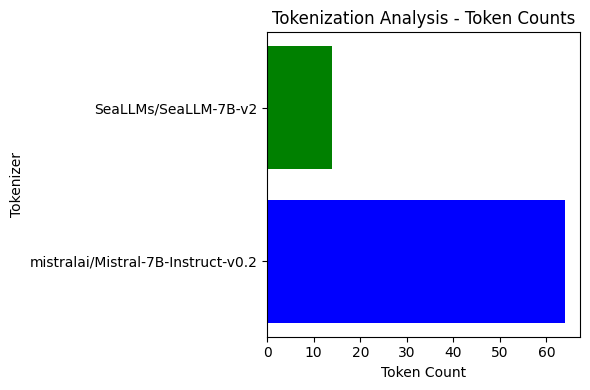

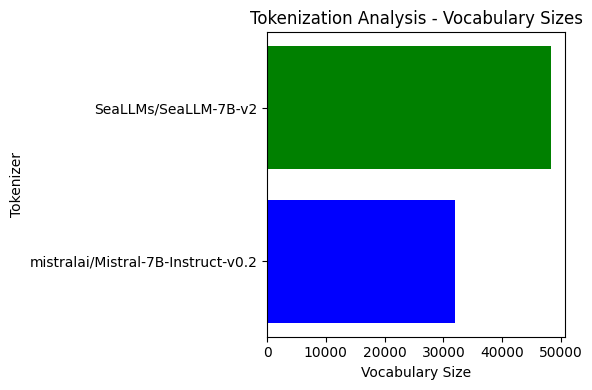

In [5]:
import matplotlib.pyplot as plt

# Define colors for each bar
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Plotting token counts
plt.figure(figsize=(6, 4))
plt.barh(tokenizer_list, token_counts, color=colors)
plt.xlabel("Token Count")
plt.ylabel("Tokenizer")
plt.title("Tokenization Analysis - Token Counts")
plt.tight_layout()
plt.show()

# Plotting vocabulary sizes
plt.figure(figsize=(6, 4))
plt.barh(tokenizer_list, vocab_sizes, color=colors)
plt.xlabel("Vocabulary Size")
plt.ylabel("Tokenizer")
plt.title("Tokenization Analysis - Vocabulary Sizes")
plt.tight_layout()
plt.show()


## Loading Source and Destination Models: Preparation for Knowledge Transfer

**In this tutorial, the following code snippet ensures you have the necessary tokenizer loaded to effectively handle text data and interact with the chosen model (Mistral-7B-Instruct-v0.2) while using the vocabulary and tokenization scheme specific to the SeaLLM-7B-v2 tokenizer.**

In [6]:
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)



Here's a breakdown of the code snippets for loading the source and destination models, highlighting their roles and the applied quantization techniques for efficiency:

**1. Configuring Quantization:**

```python
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=False,
)
```

- **Purpose:** Sets up quantization configuration for loading models with reduced precision for potential performance and memory benefits.
- **BitsAndBytesConfig:** Utilizes the BitsAndBytes library for quantization techniques.
- **Key Settings:**
    - `load_in_4bit=True`: Loads model weights in 4-bit format for memory optimization.
    - `bnb_4bit_quant_type="nf4"`: Specifies the type of 4-bit quantization (likely "near-float4").
    - `bnb_4bit_compute_dtype=torch.float16`: Uses 16-bit floating-point precision for computations, striking a balance between accuracy and efficiency.
    - `bnb_4bit_use_double_quant=False`: Disables double quantization, likely for simplicity and compatibility.

**2. Loading Model:**

```python
src_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map={"": 0}
)
```

- **Key Arguments:**
    - `model_name`: Name of the source model to load.
    - `quantization_config=bnb_config`: Applies the defined quantization configuration.
    - `device_map={"": 0}`: Specifies to load the model onto GPU device 0 for accelerated processing.


**Key Points:**

- Quantization can reduce model size and improve memory efficiency, potentially impacting speed.
- The models are loaded onto a GPU for faster processing.
- This setup prepares for transferring knowledge from the pre-trained source model to the destination model, aiming to enhance the capabilities of the destination model.

**Remember:** Consider potential model compatibility and performance implications when adjusting quantization settings. Experimentation and careful evaluation are crucial for optimal results.


In [7]:
# Load base model to transfer weight
bnb_config = BitsAndBytesConfig(
    load_in_4bit= True,
    bnb_4bit_quant_type= "nf4",
    bnb_4bit_compute_dtype= torch.float16,
    bnb_4bit_use_double_quant= False,
)
# Load base model source
src_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map={"": 0}
)
# Load base model destination
des_model = AutoModelForCausalLM.from_pretrained(
    tokenizer_name,
    quantization_config=bnb_config,
    device_map={"": 0}
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

## Understanding Input and Output Embeddings

These lines of code are used to **explore the input and output embedding layers** of the source (Mistral-7B-Instruct-v0.2) and destination (SeaLLM-7B-v2) models.

* **`get_input_embeddings()`**: This function retrieves the model's **input embedding layer**, responsible for transforming input tokens (words or subwords) into numerical representations suitable for processing by the model's internal layers.
* **`get_output_embeddings()`**: This function retrieves the model's **output embedding layer**, responsible for transforming the final hidden state of the model back into the vocabulary space. This allows the model to generate text sequences by predicting the next token based on the encoded representation.

In [8]:
print("Source input",src_model.get_input_embeddings())
print("Destination input",des_model.get_input_embeddings())

Source input Embedding(32000, 4096)
Destination input Embedding(48384, 4096)


In [9]:
print("Source output",src_model.get_output_embeddings())
print("Destination output",des_model.get_output_embeddings())

Source output Linear(in_features=4096, out_features=32000, bias=False)
Destination output Linear(in_features=4096, out_features=48384, bias=False)


In [10]:
src_model.get_input_embeddings().state_dict()

OrderedDict([('weight',
              tensor([[-0.0000e+00,  0.0000e+00, -0.0000e+00,  ..., -0.0000e+00,
                       -0.0000e+00, -0.0000e+00],
                      [-4.3640e-03, -1.0633e-04, -5.6152e-03,  ..., -5.0545e-05,
                       -1.1520e-03,  1.5926e-04],
                      [-1.7471e-03,  1.0300e-03,  3.7432e-05,  ...,  1.1826e-03,
                        3.7003e-04,  3.2425e-04],
                      ...,
                      [ 4.4556e-03, -1.3199e-03,  4.1008e-04,  ..., -4.4823e-05,
                        5.4321e-03,  1.3351e-03],
                      [-5.5313e-04,  3.3569e-03,  3.2654e-03,  ...,  1.0834e-03,
                        1.4648e-03,  9.1171e-04],
                      [-3.7842e-03, -4.8637e-04, -5.7068e-03,  ...,  4.2114e-03,
                       -4.1580e-04, -2.5330e-03]], device='cuda:0', dtype=torch.float16))])

In [11]:
des_model.get_input_embeddings().state_dict()

OrderedDict([('weight',
              tensor([[-3.5286e-04,  3.5667e-04, -8.6212e-04,  ...,  6.7711e-05,
                       -2.7466e-04, -5.1880e-04],
                      [-4.0588e-03,  1.0300e-03, -4.6997e-03,  ..., -1.1673e-03,
                       -9.0027e-04, -8.8501e-04],
                      [-1.8311e-03,  2.3556e-04, -9.9945e-04,  ...,  7.2479e-04,
                       -8.5831e-04, -5.9128e-04],
                      ...,
                      [ 5.5847e-03, -1.0669e-05,  9.0790e-04,  ..., -1.4648e-03,
                       -8.7738e-04, -2.7771e-03],
                      [ 9.6893e-04,  1.8539e-03, -1.9989e-03,  ..., -4.9210e-04,
                        1.0910e-03, -8.6975e-04],
                      [ 2.6245e-03,  1.4572e-03,  7.8964e-04,  ..., -2.7008e-03,
                       -9.0790e-04,  2.7313e-03]], device='cuda:0', dtype=torch.float16))])





By printing the information from these functions, you can potentially:

* **Compare the dimensions:** See if the input and output embedding dimensions are compatible between the two models. Significant differences might require adjustments during transfer learning.
* **Gain insights into vocabulary size:** The size of the output embedding layer might indicate the model's vocabulary size, which could be relevant for understanding the models' capabilities.

However, it's important to remember that simply observing the embedding layers might not provide extensive information about the models' inner workings or their transferability. It's crucial to analyze the overall architectures and consider other factors like the custom components and quantization used in the models.

## Analyzing Decoder Architectures: Key Components and Considerations

In [12]:
src_model.get_decoder()

MistralModel(
  (embed_tokens): Embedding(32000, 4096)
  (layers): ModuleList(
    (0-31): 32 x MistralDecoderLayer(
      (self_attn): MistralAttention(
        (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
        (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
        (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        (rotary_emb): MistralRotaryEmbedding()
      )
      (mlp): MistralMLP(
        (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
        (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
        (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): MistralRMSNorm()
      (post_attention_layernorm): MistralRMSNorm()
    )
  )
  (norm): MistralRMSNorm()
)

In [13]:
des_model.get_decoder()

MistralModel(
  (embed_tokens): Embedding(48384, 4096)
  (layers): ModuleList(
    (0-31): 32 x MistralDecoderLayer(
      (self_attn): MistralAttention(
        (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
        (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
        (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        (rotary_emb): MistralRotaryEmbedding()
      )
      (mlp): MistralMLP(
        (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
        (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
        (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): MistralRMSNorm()
      (post_attention_layernorm): MistralRMSNorm()
    )
  )
  (norm): MistralRMSNorm()
)



Here's a breakdown of the decoder architectures for both models, highlighting crucial components and considerations for transfer learning:

**Shared Characteristics:**

- **Embedding Layer:** Both models start with an embedding layer that maps input tokens to dense vector representations.
- **LayerStack:** They both utilize a `ModuleList` structure containing multiple decoder layers for sequential processing.
- **Layer Normalization:** Each decoder layer employs normalization techniques to stabilize training and improve convergence.

**Architecture-Specific Elements:**

**Mistral Model:**

- **MistralDecoderLayer:**
    - **MistralAttention:** Custom attention mechanism with quantized linear transformations and a rotary embedding for potential efficiency and modeling capabilities.
    - **MistralMLP:** Custom MLP with quantized layers and SiLU activation for non-linearity.
    - **MistralRMSNorm:** Custom RMS normalization layer.

**SeaLLM Model:**
- **MistralDecoderLayer:**
    - **MistralAttention:** Custom attention mechanism with quantized linear transformations and a rotary embedding for potential efficiency and modeling capabilities.
    - **MistralMLP:** Custom MLP with quantized layers and SiLU activation for non-linearity.
    - **MistralRMSNorm:** Custom RMS normalization layer.

**Key Considerations for Transfer Learning:**

- **Compatibility:** Examine the compatibility of layer types and dimensions to ensure smooth transfer of weights.
- **Custom Components:** Understand the effects of custom components like `MistralAttention` and `MistralMLP` on compatibility and potential knowledge transfer.
- **Quantization:** Be mindful of quantization differences and potential compatibility issues when transferring weights between quantized and non-quantized models.
- **Experimentation:** Explore different transfer strategies, such as transferring all layers or selective layers, based on architecture similarities and knowledge transfer goals.

**By carefully analyzing these decoder architectures and considering their implications, you can make informed choices about suitable transfer learning approaches and potentially achieve effective knowledge transfer between the models.**


**1. `embed_tokens` (Embedding layer):**

- This layer maps each input token (word) in a sequence to a dense embedding vector of size 4096. This embedding process captures semantic relationships between words.
- The parameter `48384` indicates the vocabulary size (the number of unique words the model can handle).

**2. `layers` (ModuleList):**

- This module list holds 32 instances of `MistralDecoderLayer`, forming the core network of the model.
- Each `MistralDecoderLayer` applies two main sub-layers: self-attention and a feed-forward network (MLP).

**3. `MistralDecoderLayer`:**

- This class represents a single processing step within the network.
- **`self_attn` (MistralAttention):**
    - This sub-layer performs **self-attention**, analyzing the relationships between words within the same input sequence.
    - It uses multiple linear projections (`Linear4bit`) to generate query (`q_proj`), key (`k_proj`), and value (`v_proj`) vectors for each token.
    - Additionally, it employs a `MistralRotaryEmbedding` layer, which is a specific type of positional encoding mechanism not commonly found in standard transformer implementations.
- **`mlp` (MistralMLP):**
    - This sub-layer acts as a feed-forward network, transforming the output of the self-attention layer.
    - It uses linear projections (`Linear4bit`) for the gate projection (`gate_proj`), the upward projection (`up_proj`), and the downward projection (`down_proj`).
    - The activation function (`act_fn`) is a specific type called "SiLU" (Sigmoid Linear Unit).
- **`input_layernorm` and `post_attention_layernorm` (MistralRMSNorm):**
    - These layers use a specific form of layer normalization (`MistralRMSNorm`) to stabilize the training process.

**4. `norm` (MistralRMSNorm):**

- This final layer applies another normalization step to the output of the entire network.

Embedding size of mistralai/Mistral-7B-Instruct-v0.2 is 32000.

Embedding size of SeaLLMs/SeaLLM-7B-v2 is 48384.

## Implementing Knowledge Transfer with Configuration Options

This section outlines the code for implementing knowledge transfer based on your choices:

```python
# Configuration options (replace with your actual choices)
transfer_input_embeddings = True
transfer_output_embeddings = False
transfer_decoder = True

# Get vocabulary size of both models
model_vocab_size = src_model.get_input_embeddings().num_embeddings
tokenizer_vocab_size = len(tokenizer.vocab)

# Check if tokenizer has a larger vocabulary
if tokenizer_vocab_size > model_vocab_size:
  print("Tokenizer vocabulary is larger than model's vocabulary. Adaptation is needed.")
  src_model.resize_token_embeddings(len(tokenizer))  # Adjust size if necessary

# Perform knowledge transfer based on configuration
if transfer_input_embeddings:
  # Transfer input embeddings
  src_model.get_input_embeddings().load_state_dict(des_model.get_input_embeddings().state_dict())

if transfer_output_embeddings:
  # Transfer output embeddings
  src_model.get_output_embeddings().load_state_dict(des_model.get_output_embeddings().state_dict())

if transfer_decoder:
  # Transfer decoder weights
  src_model.get_decoder().load_state_dict(des_model.get_decoder().state_dict())
else:
  print("Skipping decoder transfer based on your configuration.")

# Note: The code snippet does not handle the case where the tokenizer vocabulary is smaller than the model's, as it's generally not recommended.

# Proceed with further training or fine-tuning the source model with transferred knowledge
```

**Explanation:**

1. **Configuration:** Define variables like `transfer_input_embeddings`, `transfer_output_embeddings`, and `transfer_decoder` to reflect your desired transfer settings (replace with `True` or `False` based on your actual choices).
2. **Vocabulary Check:** Check if the tokenizer's vocabulary size (`tokenizer_vocab_size`) is larger than the model's vocabulary size (`model_vocab_size`).
    - If larger, a message is printed indicating adaptation might be needed.
    - The code also includes the line `src_model.resize_token_embeddings(len(tokenizer))`, which is commented out by default. This line would adjust the source model's embedding layer size to match the tokenizer's vocabulary if needed. **Use this line with caution and carefully consider potential consequences before uncommenting.**
3. **Knowledge Transfer:** Based on your configuration choices:
    - If `transfer_input_embeddings` is `True`, the weights of the input embedding layer are copied from the destination model to the source model.
    - If `transfer_output_embeddings` is `True`, the weights of the output embedding layer are copied from the destination model to the source model.
    - If `transfer_decoder` is `True`, the weights of the decoder layer are copied from the destination model to the source model.
    - If `transfer_decoder` is `False`, a message is printed stating the decoder transfer is skipped.

**Remember:**

- Experiment with different configuration options to explore the impact of knowledge transfer on the resulting model's performance.
- Carefully consider potential compatibility issues and the implications of vocabulary size differences before adapting the model's embedding layer size.

### Testing Knowledge Transfer Configurations

Here's a breakdown of the model's behavior for the three configurations you provided:

**Configuration 1**

* **Transfer Input Embeddings:** **Enabled**
* **Transfer Output Embeddings:** **Disabled**
* **Transfer Decoder:** **Disabled**

In this scenario:

- The source model's input embedding layer will be updated with weights from the destination model. This might help the source model understand the vocabulary and token representations used by the destination model, potentially improving its performance on tasks that align with the destination model's strengths.
- The source model's output embedding layer and decoder layers will **not** be modified. This means the model's output vocabulary and decoding process will remain unchanged.



In [15]:
transfer_input_embeddings = True
transfer_output_embeddings = False
transfer_decoder = False

# Get vocabulary size of both models
model_vocab_size = src_model.get_input_embeddings().num_embeddings
tokenizer_vocab_size = len(tokenizer.vocab)

# Check if tokenizer has a larger vocabulary
if tokenizer_vocab_size > model_vocab_size:
  print("Tokenizer vocabulary is larger than model's vocabulary. Adaptation is needed.")
  src_model.resize_token_embeddings(len(tokenizer))  # Adjust size if necessary

if transfer_input_embeddings == True:
  # Copy weights of the embedding layer from destination model to source
  src_model.get_input_embeddings().load_state_dict(des_model.get_input_embeddings().state_dict())

if transfer_output_embeddings == True:
  src_model.get_output_embeddings().load_state_dict(des_model.get_output_embeddings().state_dict())

if transfer_decoder == True:
  # Copy weights of the decoder layer from destination model to source
  src_model.get_decoder().load_state_dict(des_model.get_decoder().state_dict())

else:
    # Handle the case where tokenizer has smaller vocabulary (not recommended)
    print("Tokenizer vocabulary is smaller than model's vocabulary. Adaptation not needed.")


Tokenizer vocabulary is larger than model's vocabulary. Adaptation is needed.
Tokenizer vocabulary is smaller than model's vocabulary. Adaptation not needed.


In [16]:
def stream(user_prompt):
    runtimeFlag = {"": 0}
    system_prompt = 'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n'
    B_INST, E_INST = "### Instruction:\n", "### Response:\n"

    prompt = f"{system_prompt}{B_INST}{user_prompt.strip()}\n\n{E_INST}"

    inputs = tokenizer([prompt], return_tensors="pt").to(runtimeFlag)

    streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

    # Despite returning the usual output, the streamer will also print the generated text to stdout.
    _ = src_model.generate(**inputs, streamer=streamer, max_new_tokens=100)

In [17]:
stream("what is paracetamol")

Attempting to cast a BatchEncoding to type {'': 0}. This is not supported.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1477: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


无法報導orongສໍາລັບ人類 Pusဘယ်လို最新ຍາbolautri kanila kêu辦法柔维持 kayo病人 đặtလွယ် ພິ Làm sabu製品โรงเรียน社区បន្ទូលခဲສໍາເລັດ病人 digunakan chó較ပတ်သက် Joko罰 ပထမဆုံးສໍາເລັດ罰病人 kayoបន្ទូល罰 bậc membaca 全 phóng勃 ပထမဆုံး phónguncurkan đặtព្រះអង្គ賞เกิดขึ้นກໍ体制体制体制ົ່າMga umumnya体制体制 kond体制uci phóng维持ສໍາເລັດကဲ体制体制体制体制 phóng维持维持维持恆 nútကဲ ပထမဆုံး umumnya体制体制体制 ပထမဆုံး umumnya phóng以来 umumnya体制体制 ပထမဆုံး ပထမဆုံး ပထမဆုံး ပထမဆုံး成功 phóng


In [ ]:
stream("အမေရိကန်နိုင်ငံ")

In [18]:
stream("မျက်စိနာတာကို မကူးစက်အောင် ဘယ်လိုကာကွယ်ကြမလဲ!")

Attempting to cast a BatchEncoding to type {'': 0}. This is not supported.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


ခေါင်း全面尽管迅 umumnya尽管နီးดีទឹក ນາຍ成功尽管ที่ผมទឹក Siapa Mab umumnya Ibrahim olehukai umumnya Lionelສໍາລັບ柔尽管နီး gue kelu Buka လုပ်ကိုင်ဂါโรงเรียน社区 tuy umumnya Lionel xanh Lionelສໍາລັບ peringkatព្រះអង្គ umumnya不過恆 koleksi Joko ពីរ体制体制បន្ទូលháສໍາເລັດ Lionelháទទួលâu体制ធាន giá較 Ibrahim Lionel重要 Lionelhá社交ធាន đặtpta体制 Lionelร์ Lionel Lionelร์邁合作 រីឯbiz体制体制柔 က်uci phónguci phóng体制 Lionel体制体制体制体制体制体制ဂါ phónguciuci phóng


**Configuration 2**

* **Transfer Input Embeddings:** **Enabled**
* **Transfer Output Embeddings:** **Disabled**
* **Transfer Decoder:** **Enabled**

This configuration is similar to the first one, with the addition of decoder layer transfer:

- The source model's input embedding layer and decoder layers will be updated with weights from the destination model. This might benefit tasks that involve the specific decoding capabilities of the destination model.
- The source model's output embedding layer will **not** be modified, preserving its original vocabulary.

In [19]:
transfer_input_embeddings = True
transfer_output_embeddings = False
transfer_decoder = True

# Get vocabulary size of both models
model_vocab_size = src_model.get_input_embeddings().num_embeddings
tokenizer_vocab_size = len(tokenizer.vocab)

# Check if tokenizer has a larger vocabulary
if tokenizer_vocab_size > model_vocab_size:
  print("Tokenizer vocabulary is larger than model's vocabulary. Adaptation is needed.")
  src_model.resize_token_embeddings(len(tokenizer))  # Adjust size if necessary

if transfer_input_embeddings == True:
  # Copy weights of the embedding layer from destination model to source
  src_model.get_input_embeddings().load_state_dict(des_model.get_input_embeddings().state_dict())

if transfer_output_embeddings == True:
  src_model.get_output_embeddings().load_state_dict(des_model.get_output_embeddings().state_dict())

if transfer_decoder == True:
  # Copy weights of the decoder layer from destination model to source
  src_model.get_decoder().load_state_dict(des_model.get_decoder().state_dict())

else:
    # Handle the case where tokenizer has smaller vocabulary (not recommended)
    print("Tokenizer vocabulary is smaller than model's vocabulary. Adaptation not needed.")


In [20]:
stream("what is paracetamol")

Attempting to cast a BatchEncoding to type {'': 0}. This is not supported.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


ស្លាប់ລົດ sulit知道နီ紋เรียမဆိုနီ phương dikatakanနာမဆို phươngulang出席 phươngໍາနာບານမဆို phương lượt permukaanမဆို phươngาศမဆို phươngitasiិសុទ្ធမဆို phương ကိုယ့်เรียนulang cố cố khẩnื้อมันก็ phươngitasi展開 Sandiမဆိုวลitasiakuanမယ္မဆို phươngเปลี่ยนulangมันก็itasi展開 tersedia扮ภัยมันก็展開寵 Sandikonfမဆိုນີ phương cố cốvoiภัยพันธitasi menegaskanภัย phươngwakမဆို扮 bìမဆိုကြ၏။ကြ၏။voi烤ကြ၏။ วัน伺itasiမဆိုမဆိုမဆို寵မဆိုលុយကြ၏။ยอม Mabမဆို


In [21]:
stream("အမေရိကန်နိုင်ငံ")

Attempting to cast a BatchEncoding to type {'': 0}. This is not supported.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


循環မဆို寵 simula展開မဆိုារ្យနာ yên paanoမဆို寵 yênຈະ မြို့ຶກမဆို phương ipinနီး主流 phương khẩn mataยอม phương phương phương phương phương phương phương phương phương phương phương phương phương phương phương phương phương phương phương phương phương phương phương phương phương yênເວລາທີ່ phương phương phương phương phương phương phương phương phương phương phương phương phương phương phương phương phương phương yênស្ថិត Gratis桑မဆို phương phương yênuciချက်တွေvoi phương yênោរពitasi phương拉克 diren menegaskan扮 phươngແລ评论bedaမဆို phươngແລပွား Sandi Ingat


In [22]:
stream("မျက်စိနာတာကို မကူးစက်အောင် ဘယ်လိုကာကွယ်ကြမလဲ!")

Attempting to cast a BatchEncoding to type {'': 0}. This is not supported.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


phố diren出席ดย ngại主流မဆိုနာធីអោយ permukaanမဆိုမဆို ທິ နိုင်่วàm主流 phátမဆို寵 Sandivoiမဆို phươngအသက် phương主流arap主流 ລວມ只有akuan PublikCha cặpulang phươngมันก็ phươngเปลี่ยนulang yên phương diren Chính ລວມakuan pendដាក់မဆို phươngมันก็itasiချက်တွေ keju phương phương phươngมันก็ Sandiចង់只有မဆို phươngเปลี่ยนมันก็ diren múမဆို phương phương phương phương phương phương phương phương phương phương phương phương phương phương phương phương phương phương phương phương phương phương phương phương phương phương yênuciulangချက်တွေ


**Configuration 3**

* **Transfer Input Embeddings:** **Enabled**
* **Transfer Output Embeddings:** **Enabled**
* **Transfer Decoder:** **Enabled**

This configuration involves transferring weights across all three components:

- The source model's input and output embedding layers, as well as the decoder layers, will be updated with weights from the destination model. This represents the most extensive transfer of knowledge, potentially leading to significant changes in the source model's behavior. It's crucial to carefully consider compatibility between the models and the potential impact on the source model's original functionalities.



In [23]:
transfer_input_embeddings = True
transfer_output_embeddings = True
transfer_decoder = True

# Get vocabulary size of both models
model_vocab_size = src_model.get_input_embeddings().num_embeddings
tokenizer_vocab_size = len(tokenizer.vocab)

# Check if tokenizer has a larger vocabulary
if tokenizer_vocab_size > model_vocab_size:
  print("Tokenizer vocabulary is larger than model's vocabulary. Adaptation is needed.")
  src_model.resize_token_embeddings(len(tokenizer))  # Adjust size if necessary

if transfer_input_embeddings == True:
  # Copy weights of the embedding layer from destination model to source
  src_model.get_input_embeddings().load_state_dict(des_model.get_input_embeddings().state_dict())

if transfer_output_embeddings == True:
  src_model.get_output_embeddings().load_state_dict(des_model.get_output_embeddings().state_dict())

if transfer_decoder == True:
  # Copy weights of the decoder layer from destination model to source
  src_model.get_decoder().load_state_dict(des_model.get_decoder().state_dict())

else:
    # Handle the case where tokenizer has smaller vocabulary (not recommended)
    print("Tokenizer vocabulary is smaller than model's vocabulary. Adaptation not needed.")


In [24]:
stream("what is paracetamol")

Attempting to cast a BatchEncoding to type {'': 0}. This is not supported.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Paracetamol, also known as acetaminophen, is a widely used analgesic and antipyretic medication that is commonly used to relieve mild to moderate pain and reduce fever. It is a type of analgesic that is often used to treat pain, fever, and other symptoms associated with common illnesses such as headaches, toothaches, and osteoarthritis. It is available in various forms, including tablets, capsules


In [25]:
stream("အမေရိကန်နိုင်ငံ")

Attempting to cast a BatchEncoding to type {'': 0}. This is not supported.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


အမေရိကန်နိုင်ငံသည် အရှေ့ဘက်ခြမ်းတွင် တည်ရှိပြီး ၁၉ ရာစုနှောင်းပိုင်းမှစ၍ ၁ ရာစုနှောင်းပိုင်းအထိ တည်ထောင်ခဲ့ပြီး၊ အရှေ့ဘက်ခြမ်းတွင် တည်ထောင်ခဲ့ပြီး၊ အရှေ့ဘက်ခြမ်းတွင် တည်ထောင်ခဲ့ပြီး၊ အရှေ့ဘက်ခြမ်းတွင် တည်ထောင်ခဲ့ပြီး၊ အရှေ့ဘက်ခြမ်းတွင် တည်ထောင်ခဲ့ပြီး၊ အရှေ့ဘက်ခြမ်းတွင် တည်ထောင်ခဲ့ပြီး၊ အရှေ့ဘက်ခြမ်းတွင် တည်ထောင်ခဲ့ပြီး၊ အရှေ့ဘက်


In [26]:
stream("မျက်စိနာတာကို မကူးစက်အောင် ဘယ်လိုကာကွယ်ကြမလဲ!")

Attempting to cast a BatchEncoding to type {'': 0}. This is not supported.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Saccharomyces cerevisiae (S. cerevisiae) သည် မိုးဗီယို့ဗီ (Monilinia fructicola) နှင့်အတူ မိုးဗီယို့ဗီ (Monilinia fuscata) တို့၏ မျိုးဆက်သစ်များနှင့် ပေါင်းစပ်သော ပိုးမွှားများနှင့် ပိုးမွှားများမှ ထွက်ရှိသည့် ပိုးမွှားများနှင့် ပိုးမွှားများမှ ထွက်ရှိသည့် ပ


**Key Points:**

- Each configuration offers a different level of knowledge transfer with varying degrees of potential impact on the source model's behavior.
- Experimenting with these configurations and evaluating the results on your specific task is essential to determine the most effective approach for your use case.
- Be cautious when enabling full knowledge transfer as it might lead to unintended consequences if the models have significant architectural differences or incompatible functionalities.

### Modle fine-tuning (Coming soon!)

In [ ]:
# Save the fine-tuned model
src_model.save_pretrained("my_fine-tuned_model")

# Save and load the tokenizer after saving the model
tokenizer = AutoTokenizer.from_pretrained("my_fine-tuned_model")